### This notebook is heavily based on [this tutorial](https://www.tensorflow.org/hub/tutorials/tf2_text_classification). Below is the copyright info. 

In [0]:
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [2]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [0]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

X_train, y_train = tfds.as_numpy(train_data)
X_test, y_test = tfds.as_numpy(test_data)

In [4]:
print("Training entries: {}, test entries: {}".format(len(X_train), len(X_test)))


Training entries: 25000, test entries: 25000


In [5]:
X_train[:2]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [6]:
y_train

array([0, 0, 0, ..., 0, 0, 1])

In [0]:
### Use embeddings given by universal sentence encoder 
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
hub_layer = hub.KerasLayer(model, output_shape=[512], input_shape=[], 
                           dtype=tf.string, trainable=True)

In [8]:
hub_layer(X_train[:3]).shape

TensorShape([3, 512])

### Let's build a CNN on the top of embeddings given by universal sentence encoder. 

In [12]:
input = Input(shape=(), name="Input", dtype=tf.string)
x = hub_layer(input)
x = tf.keras.layers.Reshape(input_shape=(512,), target_shape=(512, 1))(x)
x = tf.keras.layers.Conv1D(128, 2, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling1D(5, padding='same')(x)
x = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling1D(5, padding='same')(x)
x = tf.keras.layers.Conv1D(128, 4, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling1D(40, padding='same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
m = Model(input, output)
m.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
reshape (Reshape)            (None, 512, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 128)          384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 103, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 103, 128)          49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 21, 128)           0   

In [0]:
m.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
x_val = X_train[:10000]
partial_x_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [15]:
history = m.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 33s 1s/step - loss: 0.7024 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 2/20
30/30 [==============================] - 32s 1s/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 3/20
30/30 [==============================] - 32s 1s/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 4/20
30/30 [==============================] - 31s 1s/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 5/20
30/30 [==============================] - 31s 1s/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 6/20
30/30 [==============================] - 31s 1s/step - loss: 0.6920 - accuracy: 0.5009 - val_loss: 0.6856 - val_accuracy: 0.4998
Epoch 7/20
30/30 [==============================] - 31s 1s/step - loss: 0.6471 - accuracy: 0.6349 - val_loss: 0.5760 - val_accuracy: 0.8438
Epoch 8/20
30/30 [==

In [16]:
results = m.evaluate(X_test, y_test)

print(results)

782/782 [==============================] - 28s 35ms/step - loss: 0.5584 - accuracy: 0.8830
[0.5584310293197632, 0.8830400109291077]


In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

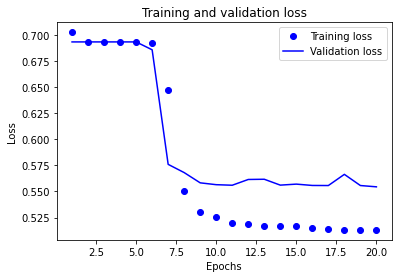

In [18]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

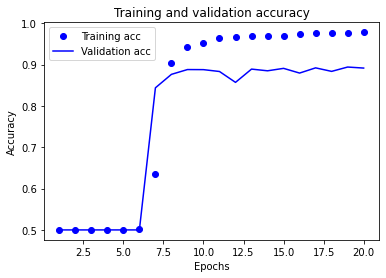

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()